**Importing libraries**

In [1]:
# Keras e TF

#import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix

# Base
import os 
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

from keras.utils import load_img

import pydot
import pydotplus
from pydotplus import graphviz

from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

from custom_resnet import ResNet18


from keras.models import Model
from keras.optimizers import Adam

**Setting path to the dataset**

In [3]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) +
              '\\adni-images-Full-resized160x192'))

In [4]:
print(os.getcwd())

c:\Users\Emili\BIOLAB_project\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192


# Loading Dataset

In [5]:

data_dir = Path(os.getcwd())

def data_mean_std():
    names = []
    for root, dirs, files in os.walk(data_dir):
        if "train_rand_under" in root:
            for file in files:
                names.append(root + '/' + file)
    
    print(len(names))
                
    array = []
    for name in names:
        img = load_img(name, color_mode = 'grayscale', target_size = (160, 192))

        img_array = np.asarray(img)
        array.append(img_array)
    
    print(img_array.shape) # Correct amount of images

    array = np.asarray(array)
    print(array.shape)
    print(array.mean().shape, array.std().shape)
    return array.mean(), array.std()
""" 
stats_file = open(stats_path, 'r')
stats_lst = stats_file.read().split('\n')
mean = float(stats_lst[0])
std = float(stats_lst[1])"""

mean, std = data_mean_std()

print(mean, std)
def normalize(x):
    return (x - mean) / std

66417
(160, 192)
(66417, 160, 192)
() ()
35.84955174217288 45.30167315348511


In [6]:

batch_size = 32 # Batch size

train_path = './train_rand_under'
test_path = './test'
valid_path = './valid'
#rescale = 1./255.
train_datagen = ImageDataGenerator(preprocessing_function = normalize)
test_datagen = ImageDataGenerator(preprocessing_function = normalize)
valid_datagen = ImageDataGenerator(preprocessing_function = normalize)

In [7]:
train_data = train_datagen.flow_from_directory(
        train_path,
        color_mode = 'grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode='categorical')

Found 66417 images belonging to 3 classes.


In [8]:
validation_data = valid_datagen.flow_from_directory(
        valid_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode='categorical')

Found 18024 images belonging to 3 classes.


In [9]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 10567 images belonging to 3 classes.


In [10]:
train_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [11]:
validation_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [12]:
test_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [13]:
train_ad = len(os.listdir(os.getcwd() + '\\train_rand_under\\ad'))
train_nor = len(os.listdir(os.getcwd() + '\\train_rand_under\\nor'))
train_mci = len(os.listdir(os.getcwd() + '\\train_rand_under\\mci'))
train_tot = train_ad + train_nor + train_mci
print(train_ad/train_tot, train_nor/train_tot, train_mci/train_tot)

0.3333333333333333 0.3333333333333333 0.3333333333333333


In [14]:
test_ad = len(os.listdir(os.getcwd() + '\\test\\ad'))
test_nor = len(os.listdir(os.getcwd() + '\\test\\nor'))
test_mci = len(os.listdir(os.getcwd() + '\\test\\mci'))
test_tot = test_ad + test_nor + test_mci
print(test_ad/test_tot, test_nor/test_tot, test_mci/test_tot)

0.22504021955143372 0.20762751963660453 0.5673322608119618


In [15]:
valid_ad = len(os.listdir(os.getcwd() + '\\valid\\ad'))
valid_nor = len(os.listdir(os.getcwd() + '\\valid\\nor'))
valid_mci = len(os.listdir(os.getcwd() + '\\valid\\mci'))
valid_tot = valid_ad + valid_nor + valid_mci
print(valid_ad/valid_tot, valid_nor/valid_tot, valid_mci/valid_tot)

0.22253661784287618 0.37377940523746117 0.4036839769196627


# Model Definition

Changing the folder to data path to save weights into

In [16]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute()) + '\\scripts\\3_Resnet18_first'))

In [17]:
os.getcwd()

'c:\\Users\\Emili\\BIOLAB_project\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\scripts\\3_Resnet18_first'

In [18]:
tb = TensorBoard(log_dir = 'logs_rand_under', write_graph = True)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=10, cooldown=0, min_lr=1e-5)

model_chkp = ModelCheckpoint(filepath=os.getcwd() + 'best_model_rand_under',
                            # monitor='val_quadratic_kappa_score',
                            monitor='val_acc',
                            save_best_only=True, save_weights_only=True, mode='max')

#resnet = ResNet18()
#resnet = ResNet18(classes=3, input_shape=(160, 192))
resnet = ResNet18(classes=3)


#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.summary()

#resnet.layers.pop()
#for layer in resnet.layers:
#    layer.trainable = False

x = resnet.layers[-1].output

x = Dropout(0.25)(x)

x = Dense(3, activation = 'softmax')(x)


ft_resnet = Model(resnet.input, x)
ft_resnet.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

print("model loaded")

ft_resnet.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
model loaded
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 166, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 80, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (

Changing back the folder to data path

In [19]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) + '\\adni-images-Full-resized160x192'))
os.getcwd()

'c:\\Users\\Emili\\BIOLAB_project\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\adni-images-Full-resized160x192'

In [20]:
epochs = 100

print(train_tot, valid_tot)

train_steps = np.ceil(train_tot/batch_size)
valid_steps = np.ceil(valid_tot/batch_size)

print (train_steps, valid_steps)

#fit_generator

ft_resnet.fit(train_data, steps_per_epoch=train_steps,
                        epochs=epochs, callbacks = [tb, model_chkp, lr_reducer],
                        validation_data=validation_data, validation_steps = valid_steps)

arch_name = 'bs_{}'.format(batch_size)

continue_model_path = os.getcwd() + 'best_model_rand_under' + '{}_{}_eps.h5'.format(arch_name, epochs)
ft_resnet.save(continue_model_path)

66417 18024
2076.0 564.0
Epoch 1/100
  24/2076 [..............................] - ETA: 1:36:02 - loss: 2.3208 - accuracy: 0.3685

KeyboardInterrupt: 

In [10]:
###########################################################################################
###########################################################################################
#Definizione del CallBacks: Early stopper sulla loss di validazione
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [50]:
version = "v1"
img_size = '112'
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/NoBalance/dcnn_model_{img_size}_{version}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_nobal = keras.Model(inputs, outputs)



In [12]:
net_dcnn_112_nobal.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 16)      448       
                                                                 
 activation (Activation)     (None, 112, 112, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 112, 112, 32)      0         
                                                             

In [13]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2),
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5),
]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)

In [14]:
# batch size 
step_per_epoch_train = len(train_data.labels) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(validation_data.labels) // batch_size
print(step_per_epoch_val)

3365
841


# Fit 

In [15]:
net_dcnn_112_nobal.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = OPTIMIZER,
            metrics=METRICS)

In [16]:
history_dcnn_nobal = net_dcnn_112_nobal.fit(train_data,
          epochs=50,
          steps_per_epoch=step_per_epoch_train,
          validation_data=validation_data,
          validation_steps=step_per_epoch_val,
          workers = 3,
          #callbacks=[model_checkpoint_callback, early_stopper])
          callbacks=[early_stopper])

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'model/dense/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Emili\AppData\Local\Temp\ipykernel_18116\3139536275.py", line 1, in <module>
      history_dcnn_nobal = net_dcnn_112_nobal.fit(train_data,
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\Emili\miniconda3\envs\biolab_project\Lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'model/dense/Relu'
Matrix size-incompatible: In[0]: [32,48384], In[1]: [18432,128]
	 [[{{node model/dense/Relu}}]] [Op:__inference_train_function_2911]

In [1]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/NoBalance/dcnn_history_{img_size}_{version}.npy',
        history_dcnn_nobal.history)

NameError: name 'np' is not defined

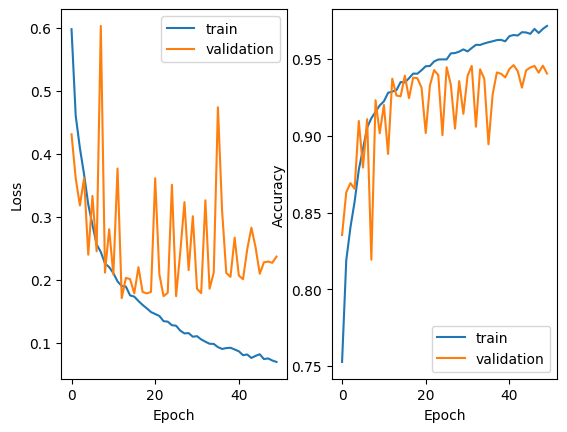

In [21]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn_nobal['loss'])
plt.plot(history_dcnn_nobal['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn_nobal['accuracy'])
plt.plot(history_dcnn_nobal['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Load Model

In [8]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/models/NoBalance')

In [9]:
# Load model
net_dcnn_112_nobal = keras.models.load_model("dcnn_model_112_v1_val_acc_best.hdf5")

In [10]:
# Load hystory and convert to dict
history = np.load('dcnn_history_112_v1.npy', allow_pickle=True).item()

# Model Evaluation

In [11]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [13]:
CATEGORIES = "COVID", "NORMAL","PNEUMONIA"

In [12]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][0:index]
    plt.plot(train_values)
    test_values = history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [14]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusion Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [15]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [16]:
def model_summary(model, history, name):       
        val_acc = history['val_accuracy'] 
        index= val_acc.index(max(val_acc))
        print('Best Epochs:', index)


        test_loss, test_accuracy, test_precision, test_recall, auc,  _ = model.evaluate(test_data, verbose=1)

        train_accuracy = history['accuracy'][index]
        train_loss = history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)

        print('---'*15) 
        print(name)
        print('> Accuracy on train:',round(train_accuracy, 2), 
                '\tLoss on train:', round(train_loss,2))


        print('> Accuracy on test:',round(test_accuracy, 2),
                '\tLoss on test:',round(test_loss,2))

        print('---'*15)
        print('> predicting test')
        print('---'*15)

        printResults(name, model)

Best Epochs: 41
13/13 [==============================] - 6s 55ms/step - loss: 0.5266 - accuracy: 0.8690 - precision: 0.8712 - recall: 0.8690 - auc: 0.9615 - top k accuracy: 1.0000


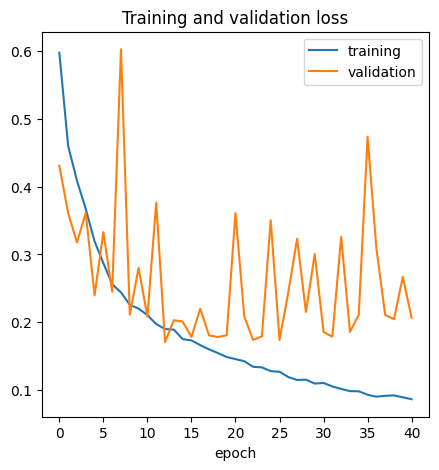

<Figure size 500x500 with 0 Axes>

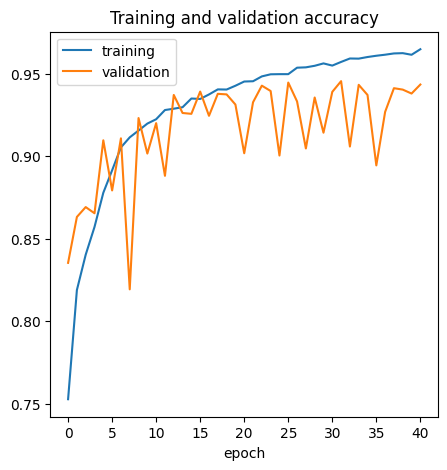

---------------------------------------------
DCCN - No Balancing
> Accuracy on train: 0.97 	Loss on train: 0.08
> Accuracy on test: 0.87 	Loss on test: 0.53
---------------------------------------------
> predicting test
---------------------------------------------
13/13 [==============================] - 0s 26ms/step


<Figure size 500x500 with 0 Axes>

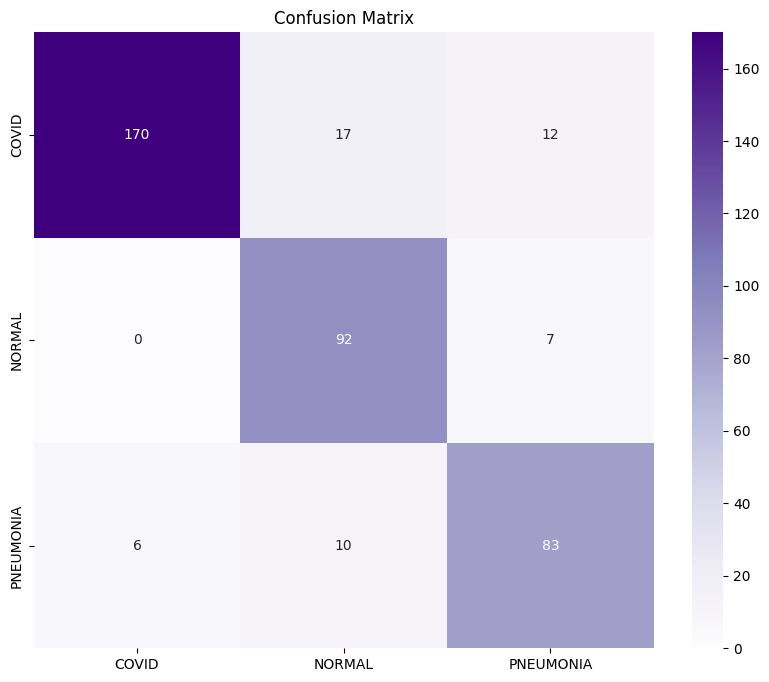

.............................................
> Correct Predictions: 345
> Wrong Predictions: 52
.............................................
              precision    recall  f1-score   support

       COVID       0.97      0.85      0.91       199
      NORMAL       0.77      0.93      0.84        99
   PNEUMONIA       0.81      0.84      0.83        99

    accuracy                           0.87       397
   macro avg       0.85      0.87      0.86       397
weighted avg       0.88      0.87      0.87       397



In [18]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112')
model_summary(net_dcnn_112_nobal, history, 'DCCN - No Balancing')